# Exploratory Data Analysis

Let's now re-visit the data we previously extracted and cleaned to understand it better. We will create easy visualization to explore the data and try to answer some of the questions we asked in the beginning:

- How do mental health disorders and mental health support measures differ across age, sex, race and work position?
- How has the trend in diagnoses and support changed over the years? 
- Who would benefit the most from additional programs?
- What do individuals in the survey believe would improve mental health support in their companies?

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import researchpy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from py_functions.utilities_functions import normality_and_homoscedasticity_tests, print_contingency_table, chi_squared_plot

[nltk_data] Downloading package vader_lexicon to /home/alessio-
[nltk_data]     pc/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
# Set styles for plots
qualitative_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

palette = 'crest'
style = 'darkgrid'

font = {'family': 'serif', 'size': 12}

# Set seaborn palette and style
sns.set(palette=palette, style=style, font=font)
plt.rc('font', **font)

In [7]:
df_folder = "data/clean_data"

# Construct the relative file path
df = pd.read_csv(df_folder + "/cleaned_data.csv")
df.head()

,id,benefits,resources,mhd,coworker_chat,race,support_options,age,sex
0,1,Yes,NaN,NaN,NaN,NaN,No,37.0,Female
1,2,Don't know,NaN,NaN,NaN,NaN,No,44.0,Male
2,3,No,NaN,NaN,NaN,NaN,No,32.0,Male
3,4,No,NaN,NaN,NaN,NaN,No,31.0,Male
4,5,Yes,NaN,NaN,NaN,NaN,Yes,31.0,Male


Let's quickly analyse the age distribution over the various columns we have available.

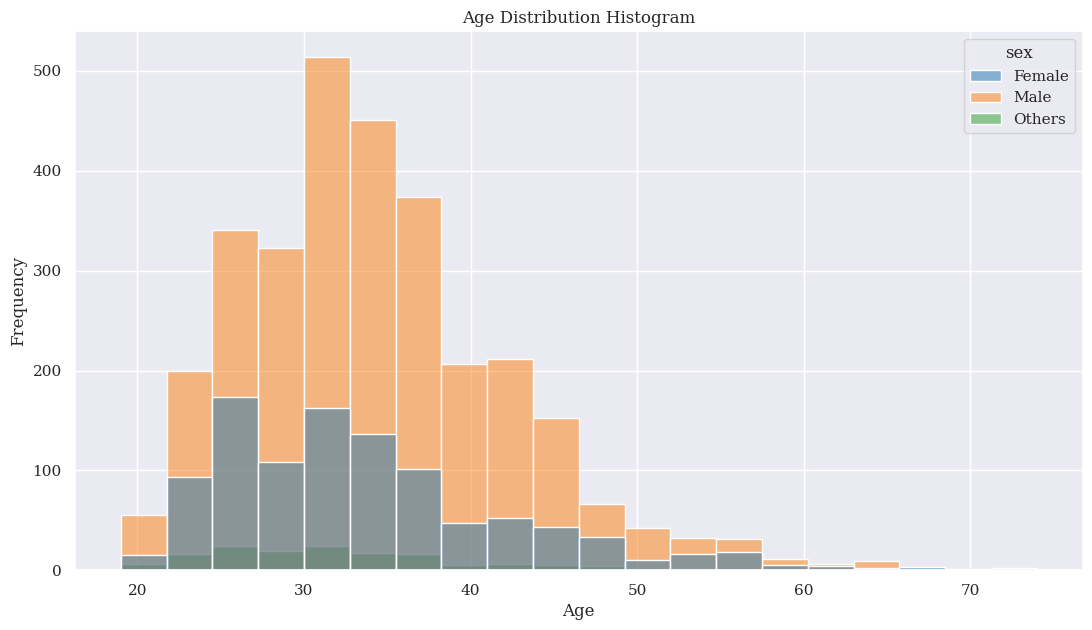

In [8]:
fig, ax = plt.subplots(figsize=(13, 7))
sns.histplot(data=df, x='age',bins=20, hue='sex', palette=qualitative_colors[:3]) 
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution Histogram')
plt.show()

Earlier we saw the majority of individuals reported having been diagnosed with a mental health disorder now or in the past, let's analyse this data and how it compares with age and sex.

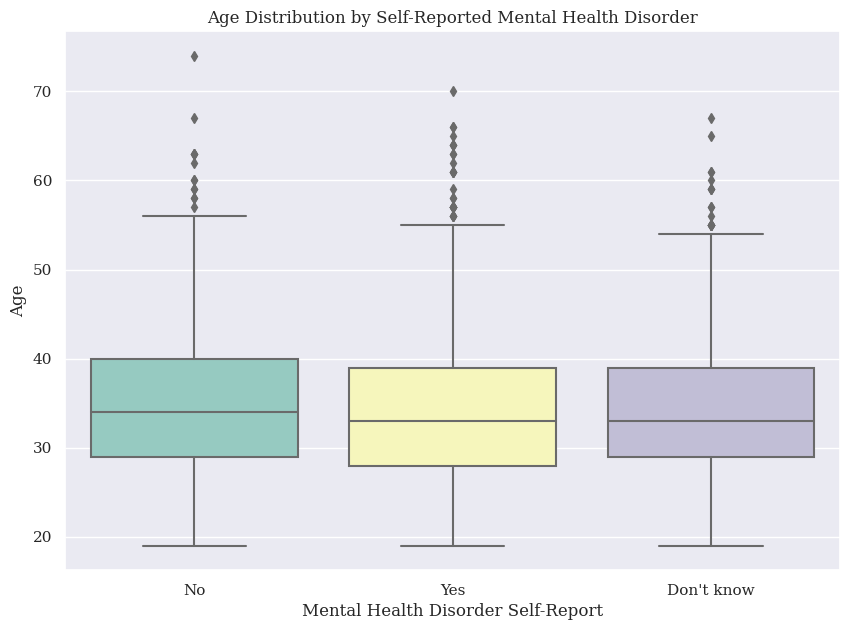

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(data=df, x='mhd', y='age', palette='Set3')
plt.xlabel('Mental Health Disorder Self-Report')
plt.ylabel('Age')
plt.title('Age Distribution by Self-Reported Mental Health Disorder')
plt.show()

Starting with an analysis on the age distribution, we saw earlier that there are more males than females. Since the numbers for reported mental health disorder are seemingly equal for all genders, and males far outnumber females, we need to normalize the gender distributions to understand it better. 

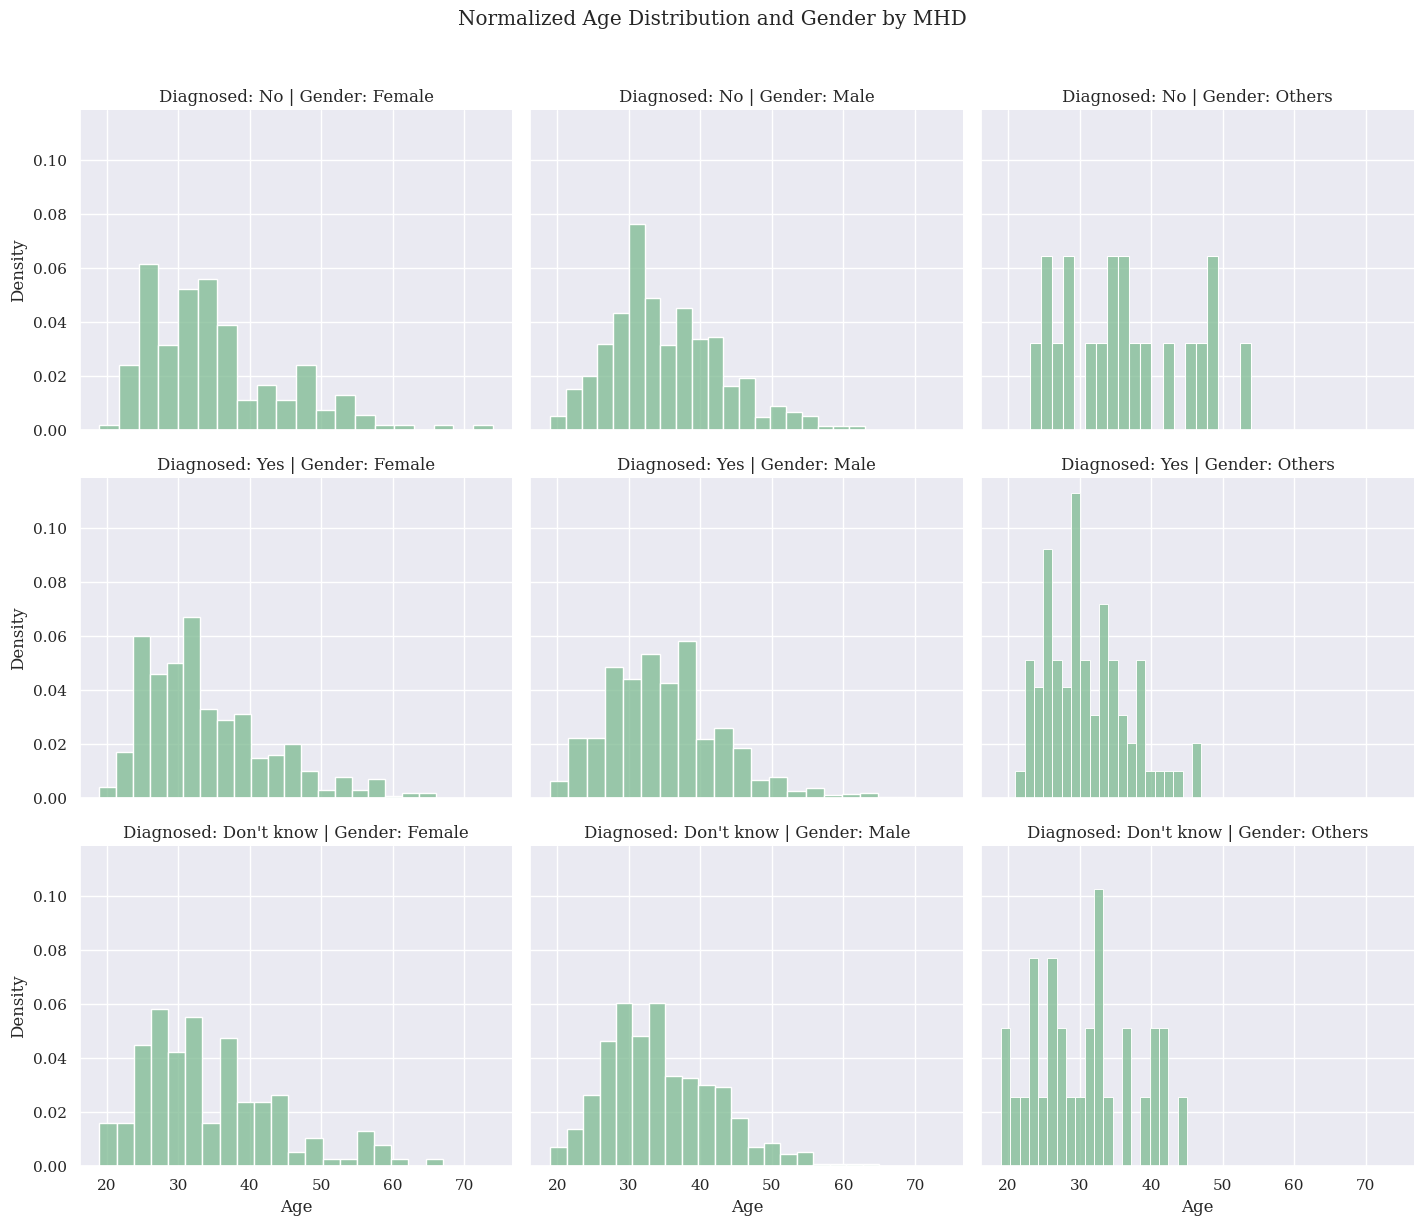

In [10]:
# Calculate the total count for standardizing males and females reports
total_males = (df['sex'] == 'Male').sum()
total_females = (df['sex'] == 'Female').sum()

g = sns.FacetGrid(df, row='mhd', col='sex', height=4, aspect=1.2)
g.map_dataframe(
    lambda data, color: sns.histplot(data['age'], bins=20, stat='density'),
    color=qualitative_colors
)

g.set_axis_labels('Age', 'Density')
g.set_titles(row_template='Diagnosed: {row_name}', col_template='Gender: {col_name}')
g.fig.suptitle('Normalized Age Distribution and Gender by MHD', y=1.02)

plt.tight_layout()
plt.show()


After normalizing the distributions for genders, we will try to see if any of the previously chosen variables has an impact based on how the ages are distributed. Before starting with tests like ANOVA to determine the size of the impacts for all the variables, let's first check for normality and homoscedasticity.

In [11]:
variables = ['benefits', 'resources', 'mhd', 'coworker_chat', 'support_options']

for var in variables:
    print(f'Checking normality and homoscedasticity for {var}:\n')
    print()
    normality_and_homoscedasticity_tests(df, 'age', var)
    print("*" * 80)

Checking normality and homoscedasticity for benefits:


Shapiro-Wilk Test Results:
Group: Yes, Shapiro Statistic: 0.9570537805557251, p-value: 3.241737430850536e-22
Group: Don't know, Shapiro Statistic: 0.9528704881668091, p-value: 5.087576654670353e-23
Group: No, Shapiro Statistic: 0.9307384490966797, p-value: 3.933242985509034e-18

Bartlett Test Results:
Group: benefits, Bartlett Statistic: 16.218424302059255, p-value: 0.0003007557299676014
********************************************************************************
Checking normality and homoscedasticity for resources:


Shapiro-Wilk Test Results:
Group: No, Shapiro Statistic: 0.9481830596923828, p-value: 4.652256601478529e-19
Group: Yes, Shapiro Statistic: 0.9615931510925293, p-value: 1.4259145079964508e-12
Group: Don't know, Shapiro Statistic: 0.9614109396934509, p-value: 5.188040075113392e-17

Bartlett Test Results:
Group: resources, Bartlett Statistic: 15.498237517578163, p-value: 0.00043112229595720886
*********************

Since all of the data we have does not follow normality and homoscedasticity, we need to proceed with non-parametric tests. I chose Kruskal-Wallis tests for this analysis.

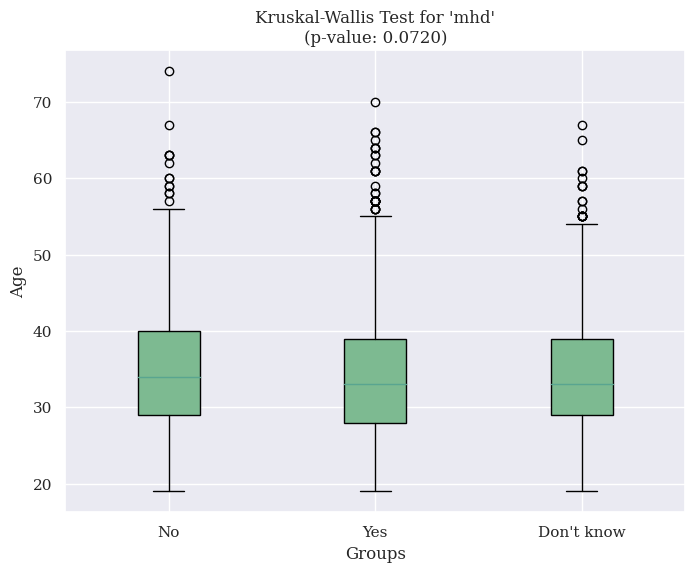

Results for Kruskal-Wallis test:

'Column': 'mhd', 'Statistics': 5.2615169878053925, 'p-value': 0.0720238118932393


In [12]:
filtered_data = df.dropna(subset=['mhd', 'age']) 

groups = filtered_data['mhd'].unique()
group_data = [filtered_data[filtered_data['mhd'] == group]['age'] for group in groups]

stat, p = scipy.stats.kruskal(*group_data)

# Create a grouped box plot for 'mhd' with colored boxes
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(group_data, labels=groups, patch_artist=True)
ax.set_title(f"Kruskal-Wallis Test for 'mhd'\n(p-value: {p:.4f})")
ax.set_xlabel('Groups')
ax.set_ylabel('Age')
plt.show()

print('Results for Kruskal-Wallis test:\n')
print(f"'Column': 'mhd', 'Statistics': {stat}, 'p-value': {p}")


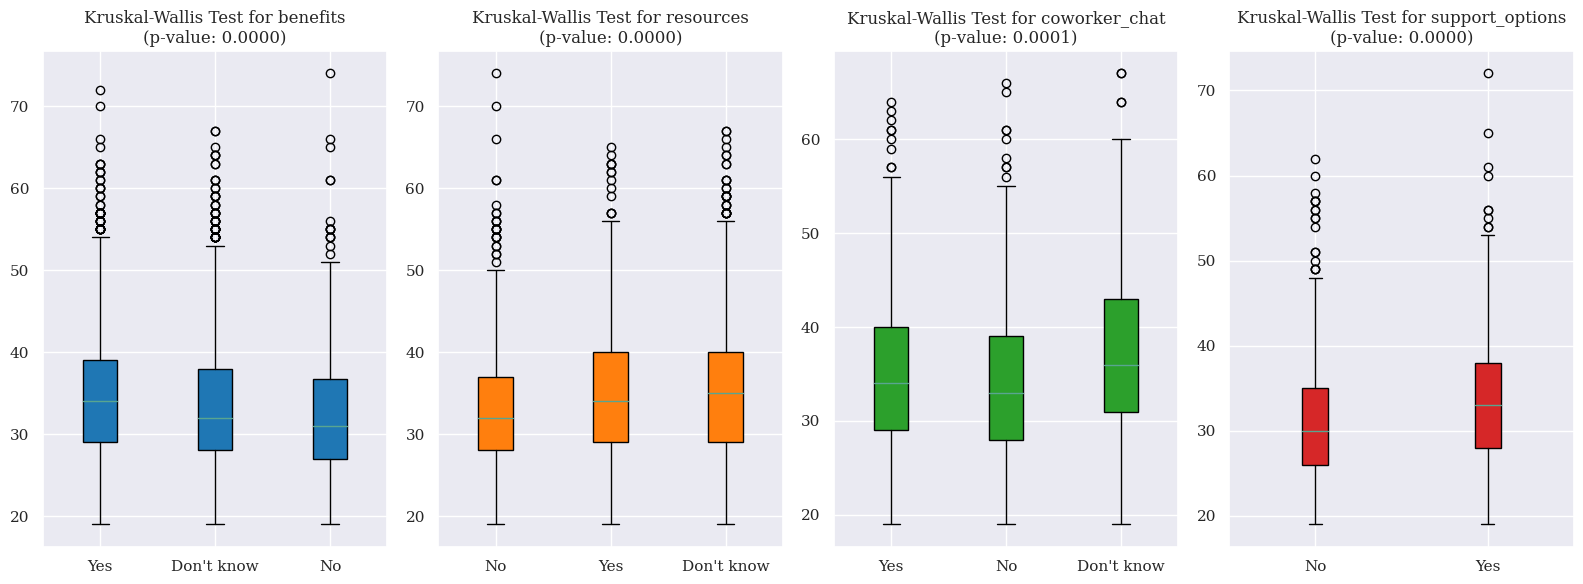

Results for Kruskal-Wallis test:

Column: benefits, Statistics: 51.82825809142801, p-value: 5.567199085120043e-12
Column: resources, Statistics: 67.92566341964053, p-value: 1.7788101488585346e-15
Column: coworker_chat, Statistics: 17.70967096210076, p-value: 0.00014269009017602914
Column: support_options, Statistics: 28.153593818586987, p-value: 1.1205939926330749e-07


In [13]:
columns_to_test = ['benefits', 'resources', 'coworker_chat', 'support_options']

kruskal_results = []

# Create subplots for each column
fig, axes = plt.subplots(nrows=1, ncols=len(columns_to_test), figsize=(16, 6))
colors = qualitative_colors

for i, column in enumerate(columns_to_test):
    filtered_data = df.dropna(subset=[column, 'age']) 
    
    groups = filtered_data[column].unique()
    group_data = [filtered_data[filtered_data[column] == group]['age'] for group in groups]
    
    if len(group_data) > 1:
        stat, p = scipy.stats.kruskal(*group_data)
        kruskal_results.append({'Column': column, 'Statistics': stat, 'p-value': p})
        
        # Create a grouped box plot with colored boxes
        ax = axes[i]
        ax.boxplot(group_data, labels=groups, patch_artist=True, boxprops=dict(facecolor=colors[i]))
        ax.set_title(f"Kruskal-Wallis Test for {column}\n(p-value: {p:.4f})")

plt.tight_layout()
plt.show()

print('Results for Kruskal-Wallis test:\n')
for result in kruskal_results:
    print(f"Column: {result['Column']}, Statistics: {result['Statistics']}, p-value: {result['p-value']}")


The Kruskal-Wallis test was performed to examine the impact of various categorical factors (benefits, resources, mhd, coworker_chat and support_options) on the age of individuals in the dataset. The results indicate that:

'benefits,' 'resources,' and 'support_options' have a significant impact on age, with substantial evidence to suggest that these factors are influenced by age differences.

Conversely, 'mhd' and 'coworker_chat' do not appear to be significantly affected by age.

These findings provide valuable insights into how specific factors relate to the age distribution in the dataset.

These results are telling us that there is a significant difference in age distribution among the groups within the subset of the data where both age and the 'resources' column have non-null values. In other words, it's specific to the subset of the data that has valid age and 'resources' information. The Kruskal-Wallis test, in this context, does not make broader claims about the entire dataset or the general population; it focuses on the subset where both age and 'resources' information is available.

Let's proceed with an analysis of the same categorical variables and gender, using the Chi-Squared test which is apt for comparison of categorical variables.

                Chi-square test   results
0  Pearson Chi-square ( 4.0) =   102.4166
1                    p-value =     0.0000
2                 Cramer's V =     0.1318

Tables for mhd and sex:

sex         Female  Male  Others
mhd                             
Don't know     158   561      30
No             195   750      20
Yes            424   735      75


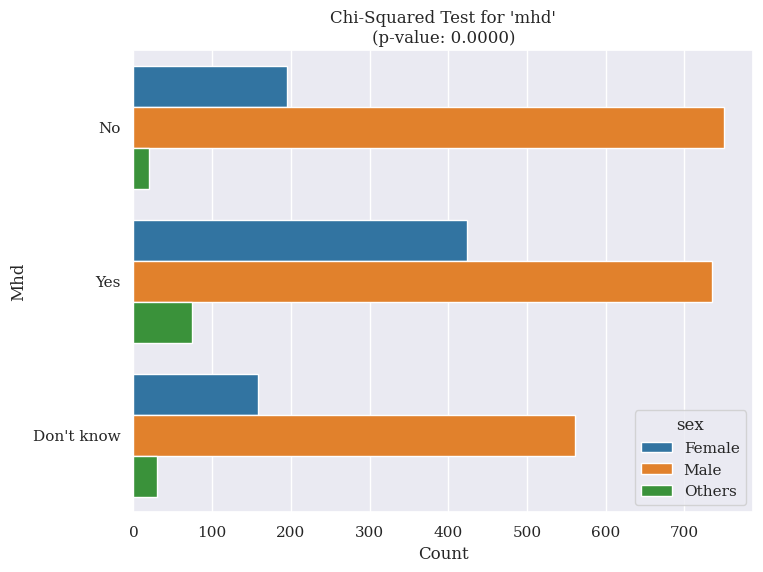

sex         Female  Male  Others
mhd                             
Don't know     158   561      30
No             195   750      20
Yes            424   735      75

mhd
Don't know    0.203346
No            0.250965
Yes           0.545689
Name: Female, dtype: float64


mhd
Don't know    0.274194
No            0.366569
Yes           0.359238
Name: Male, dtype: float64


mhd
Don't know    0.24
No            0.16
Yes           0.60
Name: Others, dtype: float64



In [14]:
table_mhd = chi_squared_plot(df, 'mhd', 'sex', hue='sex',color_palette=qualitative_colors)

print(table_mhd)
print_contingency_table(table_mhd)

We can see there is a signficant difference in the distribution of mental health disorders within the reported genders. Based on the proportions, it looks like there are more people with mental health disorders than no mental health disorders. Relative to the specific gender group of males, females and non-binary individuals have higher proportions of mental health disorders.

Now, what about the other categorical variables? We will run an overall test similar to the Kruskal-Wallis test we did before.

Column: benefits

sex
Female    0.223199
Male      0.739309
Others    0.037493
Name: Don't know, dtype: float64


sex
Female    0.157333
Male      0.825333
Others    0.017333
Name: No, dtype: float64


sex
Female    0.301670
Male      0.660334
Others    0.037997
Name: Yes, dtype: float64

Column: resources

sex
Female    0.230043
Male      0.732189
Others    0.037768
Name: Don't know, dtype: float64


sex
Female    0.253001
Male      0.700831
Others    0.046168
Name: No, dtype: float64


sex
Female    0.335714
Male      0.620000
Others    0.044286
Name: Yes, dtype: float64

Column: coworker_chat

sex
Female    0.240909
Male      0.686364
Others    0.072727
Name: Don't know, dtype: float64


sex
Female    0.264881
Male      0.687500
Others    0.047619
Name: No, dtype: float64


sex
Female    0.334395
Male      0.605096
Others    0.060510
Name: Yes, dtype: float64

Column: support_options

sex
Female    0.199317
Male      0.783599
Others    0.017084
Name: No, dtype: float64


sex
Female 

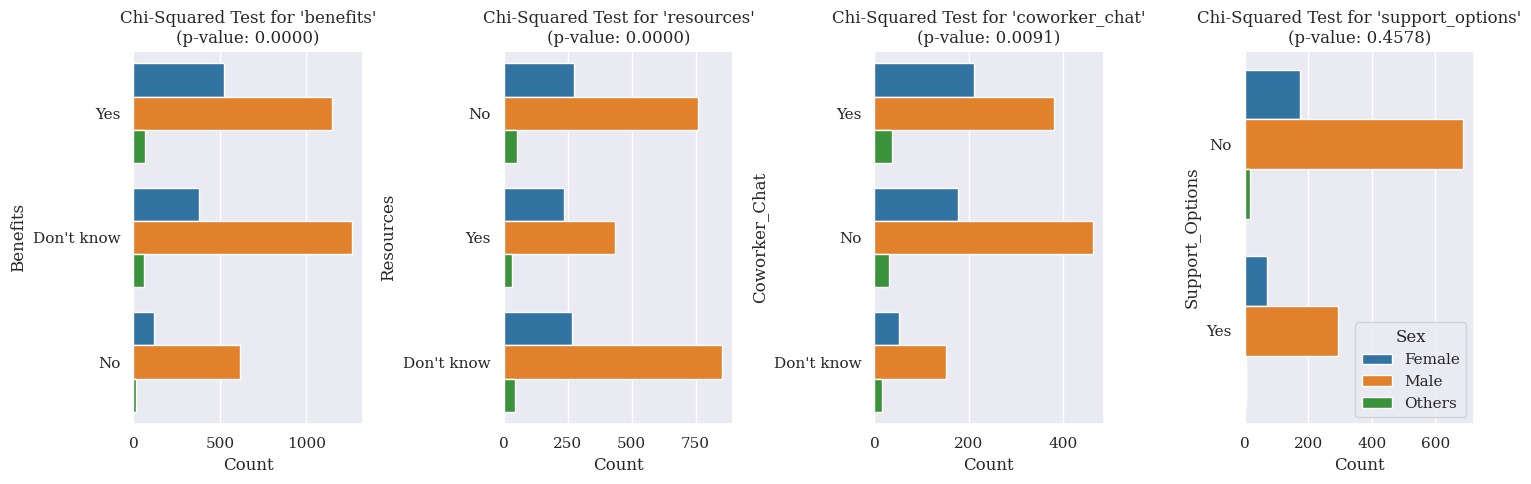

Results for Chi-Squared tests:

Column: benefits, Chi-Squared: 78.28919330310535, p-value: 4.0118508307908954e-16
Column: resources, Chi-Squared: 28.305423843416964, p-value: 1.0815476925193742e-05
Column: coworker_chat, Chi-Squared: 13.498781043427444, p-value: 0.009079135285299026
Column: support_options, Chi-Squared: 1.5627704676129626, p-value: 0.45777145140964914


In [15]:
categorical_columns = ['benefits', 'resources', 'coworker_chat', 'support_options']

chi_squared_results = []

# Create a figure with subplots
fig, axes = plt.subplots(1, len(categorical_columns), figsize=(15, 5))

for i, column in enumerate(categorical_columns):
    contingency_table = pd.crosstab(df['sex'], df[column])
    
    chi2, p, _, _ = scipy.stats.chi2_contingency(contingency_table)
    chi_squared_results.append({'Column': column, 'Chi-Squared': chi2, 'p-value': p})

    # Create a count plot with hue 'sex' (only legend for the last plot)
    sns.countplot(data=df, y=column, hue='sex', ax=axes[i], palette=qualitative_colors)
    axes[i].set_title(f"Chi-Squared Test for '{column}'\n(p-value: {p:.4f})")
    axes[i].set_ylabel(column.title())
    axes[i].set_xlabel('Count')
    axes[i].get_legend().remove()

    print(f"Column: {column}")
    print_contingency_table(contingency_table)

# Add a single legend at the end
axes[-1].legend(loc='lower right', title='Sex')

plt.tight_layout()
plt.show()

print('Results for Chi-Squared tests:\n')
for result in chi_squared_results:
    print(f"Column: {result['Column']}, Chi-Squared: {result['Chi-Squared']}, p-value: {result['p-value']}")


These results suggest that there are significant associations between 'sex' and the other categorical variables, except for 'support_options,' where the relationship is not significant. The significant relationships indicate that 'sex' is associated with differences in responses for 'benefits,' 'resources,' and 'coworker_chat', where males were more likely to answer 'No' to all of these questions. 

However, we can also see how females answered 'Yes' more often to having benefits and chats with coworkers about mental health. 

Let's now quickly look at the last categorical variable of interest: race.

In [16]:
df['race'].value_counts()

race
White                               872
More than one of the above           35
Asian                                31
I prefer not to answer               29
Black or African American            15
American Indian or Alaska Native      1
Hispanic                              1
White Hispanic                        1
European American                     1
Caucasian                             1
Name: count, dtype: int64

As we have previously seen, the race column has a lot of reported 'White' values. These skew our analysis a lot, making it even less valid and generalizable than it already was. 

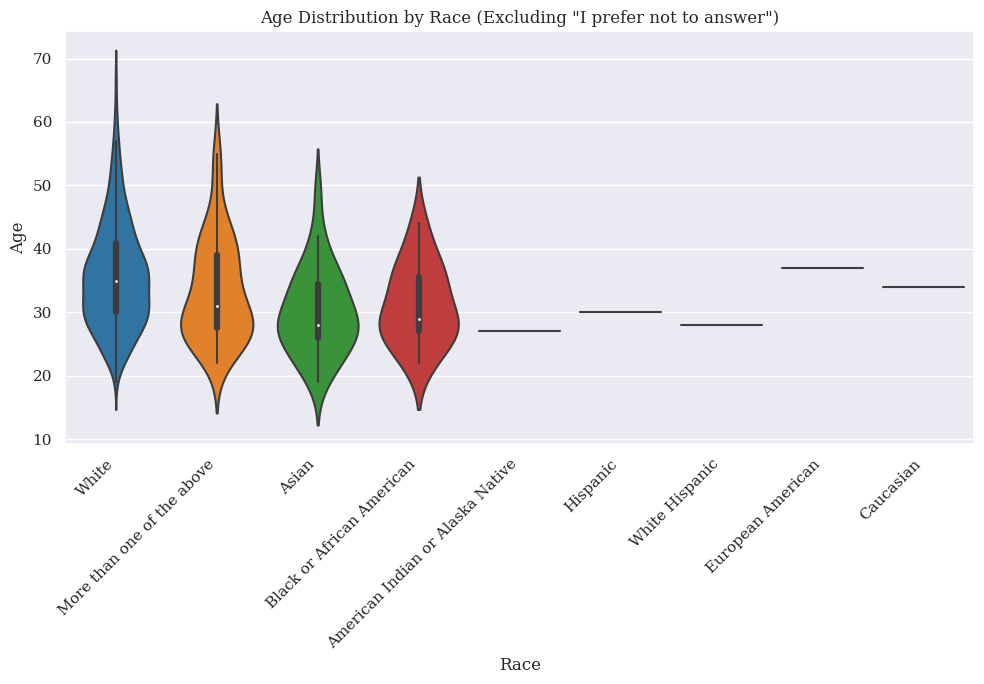

In [17]:
df_filtered = df[df['race'] != 'I prefer not to answer']

fig, ax = plt.subplots(figsize=(10, 7))
sns.violinplot(data=df_filtered, x='race', y='age', palette=qualitative_colors)

plt.xlabel('Race')
plt.ylabel('Age')
plt.title('Age Distribution by Race (Excluding "I prefer not to answer")')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

                 Chi-square test  results
0  Pearson Chi-square ( 16.0) =   32.1668
1                     p-value =    0.0095
2                  Cramer's V =    0.1296

Tables for mhd and race:

race        American Indian or Alaska Native  Asian  \
mhd                                                   
Don't know                                 0      5   
No                                         1     16   
Yes                                        0     10   

race        Black or African American  Caucasian  European American  Hispanic  \
mhd                                                                             
Don't know                          4          0                  0         0   
No                                  0          0                  1         1   
Yes                                11          1                  0         0   

race        More than one of the above  White  White Hispanic  
mhd                                                        

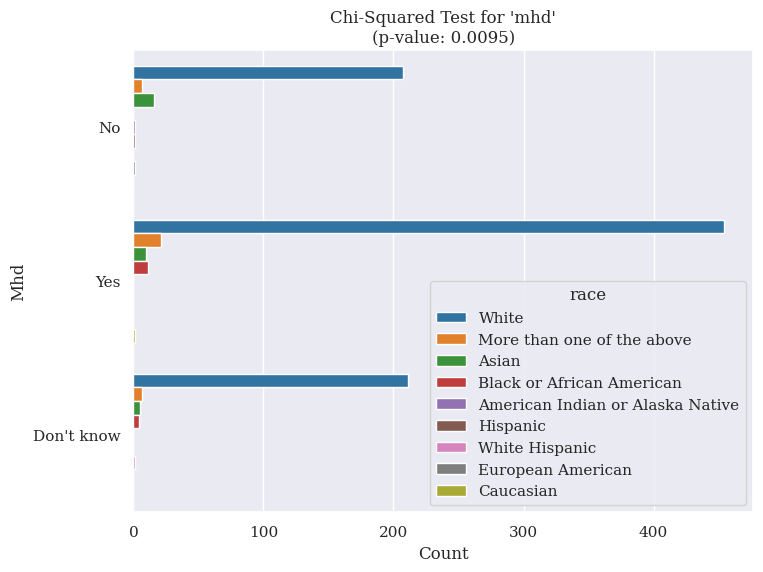

race        American Indian or Alaska Native  Asian  \
mhd                                                   
Don't know                                 0      5   
No                                         1     16   
Yes                                        0     10   

race        Black or African American  Caucasian  European American  Hispanic  \
mhd                                                                             
Don't know                          4          0                  0         0   
No                                  0          0                  1         1   
Yes                                11          1                  0         0   

race        More than one of the above  White  White Hispanic  
mhd                                                            
Don't know                           7    211               1  
No                                   7    207               0  
Yes                                 21    454               0 

In [18]:
table_race = chi_squared_plot(df_filtered, 'mhd', 'race', hue='race',color_palette=qualitative_colors)

print(table_race)
print_contingency_table(table_race)

In summary, the chi-squared test suggests that there is a statistically significant association between race and the presence of a mental health disorder. However, the strength of this association is relatively weak to moderate, as indicated by Cramer's V. The data also suggests that a higher percentage of Black or African American individuals report having an mhd compared to other racial categories. However, it's important to note that these observations are based on a relatively small sample size for some racial categories, so the results should be interpreted with caution.

Let's look once more at the other categorical variables.

In [19]:
mask = df_filtered['race'].notna() & df_filtered['support_options'].notna()
df_filtered[mask]

,id,benefits,resources,mhd,coworker_chat,race,support_options,age,sex


So, these results are important. Similar to sex, we have significantly different proportions of mental health diagnoses. But, unlike sex, we are not seeing the corresponding increase in benefits or resources for these individuals, nor do we see a significant effect of the race onto the various categories signifying that it did not actually mattered.

Column: benefits

race
American Indian or Alaska Native    0.002950
Asian                               0.041298
Black or African American           0.011799
Caucasian                           0.002950
European American                   0.002950
Hispanic                            0.002950
I prefer not to answer              0.029499
More than one of the above          0.041298
White                               0.861357
White Hispanic                      0.002950
Name: Don't know, dtype: float64


race
American Indian or Alaska Native    0.000000
Asian                               0.024390
Black or African American           0.000000
Caucasian                           0.000000
European American                   0.000000
Hispanic                            0.000000
I prefer not to answer              0.073171
More than one of the above          0.048780
White                               0.853659
White Hispanic                      0.000000
Name: No, dtype: float64


race
Ameri

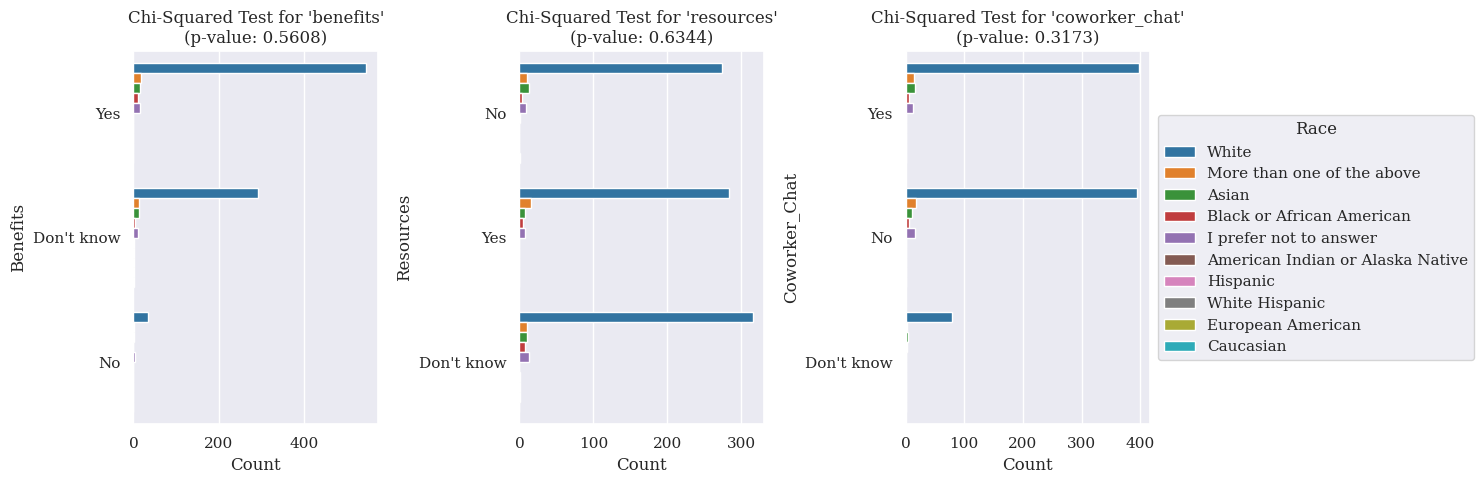

Results for Chi-Squared tests:

Column: benefits, Chi-Squared: 16.455056501520648, p-value: 0.5608212046047766
Column: resources, Chi-Squared: 15.399153813581576, p-value: 0.6344021333126217
Column: coworker_chat, Chi-Squared: 20.28039039294618, p-value: 0.3172571130305252


In [20]:
categorical_columns = ['benefits', 'resources', 'coworker_chat']

chi_squared_results = []

# Create a figure with subplots
fig, axes = plt.subplots(1, len(categorical_columns), figsize=(15, 5))

for i, column in enumerate(categorical_columns):
    contingency_table = pd.crosstab(df['race'], df[column])
    
    chi2, p, _, _ = scipy.stats.chi2_contingency(contingency_table)
    chi_squared_results.append({'Column': column, 'Chi-Squared': chi2, 'p-value': p})

    # Create a count plot with hue 'sex' (only legend for the last plot)
    sns.countplot(data=df, y=column, hue='race', ax=axes[i], palette=qualitative_colors)
    axes[i].set_title(f"Chi-Squared Test for '{column}'\n(p-value: {p:.4f})")
    axes[i].set_ylabel(column.title())
    axes[i].set_xlabel('Count')
    axes[i].get_legend().remove()

    print(f"Column: {column}")
    print_contingency_table(contingency_table)

# Add a single legend to the right of the last plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Race')

plt.tight_layout()
plt.show()

print('Results for Chi-Squared tests:\n')
for result in chi_squared_results:
    print(f"Column: {result['Column']}, Chi-Squared: {result['Chi-Squared']}, p-value: {result['p-value']}")


# So, where are more support and benefits needed?

- A proposal could be to enhance training for upper management or propose more informal meetings on the topics. This is due to the higher proportions of mental health disorders reported by females and nonbinary individuals compared to males, but who also did not seem more likely to be willing to discuss about it.

- Resources and support for African American individuals with mental health disorders. We saw a higher proportions of reported mental health disorders in African American individuals but no difference in mental health resources.

There is still some interesting aspects that we left behind, such as remote work or whether the support was deemed good or bad by respondents. 

Now, we will turn to another important section of the data which is the direct answers the individuals gave to the question about how they believe the work place could improve the mental health support.

In [21]:
# Construct the relative file path
improve_df = pd.read_csv(df_folder + "/improvements.csv")
improve_df.head()

,id,improvements
0,2694,They don't take it seriously
1,2695,"raise awareness, talk about it to lessen the s..."
2,2696,"Education and awareness, statistics, add suppo..."
3,2697,"More support, less burnout and death marches"
4,2698,I think tech is more internal and they don't r...


We are going to analyse the content of the improvements column. To do this, we will add a few columns, showing the word count, characters count and average word length. This will be used later for a sentiment analysis on the responses.

In [22]:
improve_df['word_count'] = improve_df['improvements'].apply(lambda x: len(nltk.word_tokenize(x)))
improve_df['char_count'] = improve_df['improvements'].apply(len)
improve_df['avg_word_length'] = improve_df.apply(lambda row: row['char_count'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)

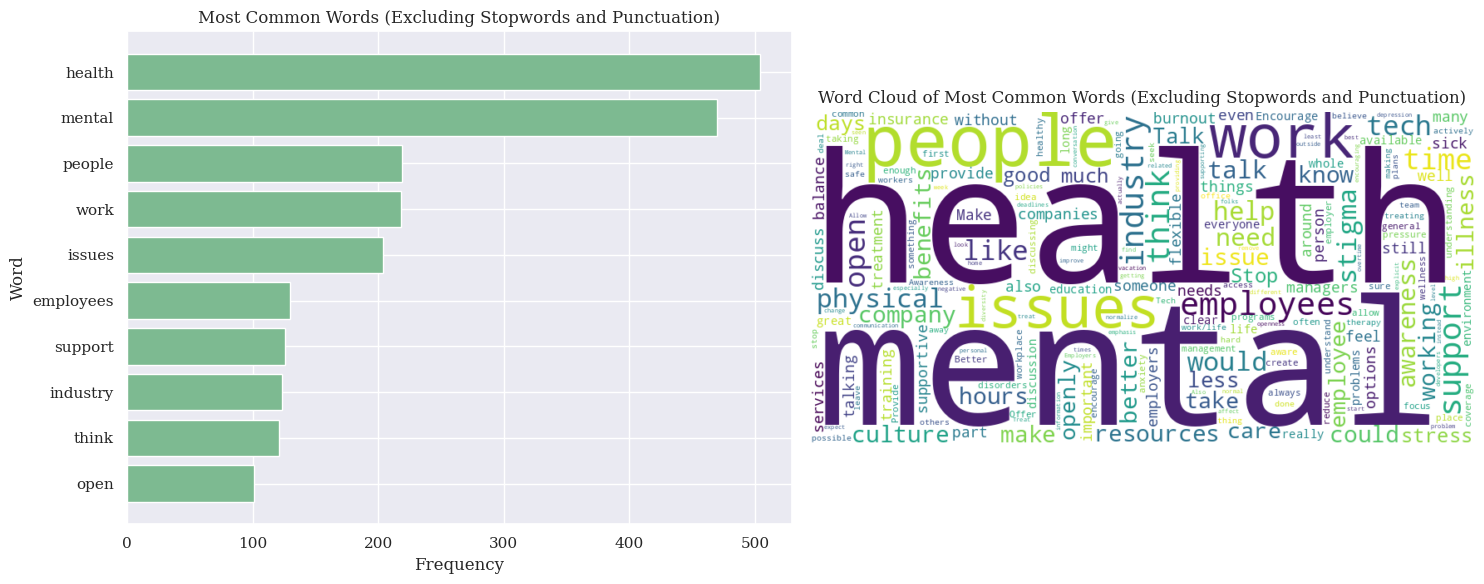

In [23]:
# Tokenize the text and calculate the frequency of each word
word_counts = Counter()
for text in improve_df['improvements']:
    tokens = nltk.word_tokenize(text)
    word_counts.update(tokens)

stop_words = set(stopwords.words('english'))

# Remove stopwords, punctuation and words less than 3 characters from the word counts 
filtered_word_counts = [(word, count) for word, count in word_counts.items() if word.lower() not in stop_words and len(word) > 3]


filtered_word_counts.sort(key=lambda x: x[1], reverse=True)
most_common_words = filtered_word_counts[:10]

# Create a WordCloud object that uses all filtered words, not just top 10
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(dict(filtered_word_counts))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the bar chart on the first subplot
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
axes[0].barh(common_words_df['Word'], common_words_df['Frequency'])
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Word')
axes[0].set_title('Most Common Words (Excluding Stopwords and Punctuation)')
axes[0].invert_yaxis()

# Display the word cloud on the second subplot
axes[1].imshow(wordcloud, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud of Most Common Words (Excluding Stopwords and Punctuation)')

plt.tight_layout()
plt.show()


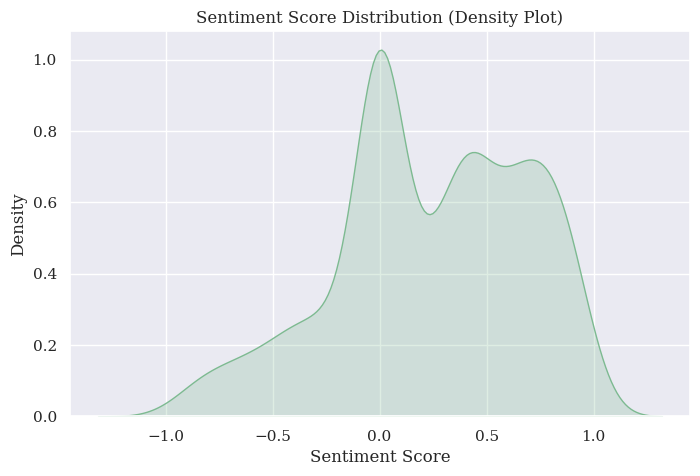

In [24]:
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each response higher than 2 chars
improve_df = improve_df[improve_df['word_count'] >= 2]
improve_df['sentiment'] = improve_df['improvements'].apply(lambda x: sia.polarity_scores(x)['compound'])


plt.figure(figsize=(8, 5))
sns.kdeplot(data=improve_df['sentiment'], shade=True)
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Sentiment Score Distribution (Density Plot)')
plt.show()


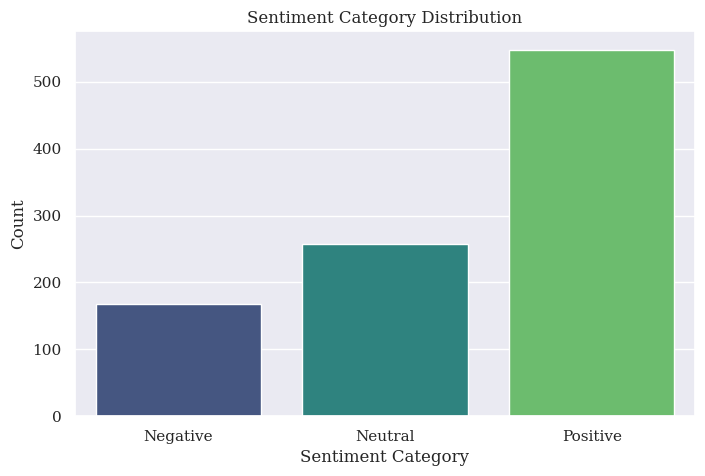

In [25]:
# Define a threshold for categorizing sentiment scores
threshold = 0.1
improve_df['sentiment_category'] = improve_df['sentiment'].apply(lambda x: 'Positive' if x > threshold else ('Negative' if x < -threshold else 'Neutral'))

plt.figure(figsize=(8, 5))
sns.countplot(data=improve_df, x='sentiment_category', order=['Negative', 'Neutral', 'Positive'], palette='viridis')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.title('Sentiment Category Distribution')
plt.show()


Based on this quick analysis of text from respondents to the survey, we can see a few common topics:

- Improving work-life balance and work hours
- Openly discussing and talking about mental health issues to improve awareness
- Working on reducing stigma around mental health and mental health discussions
- More discussion on the current benefits and resources for mental health

Many respondents showed positive sentiment to their responses. The prevalence of positive feedback can serve as a valuable resource for crafting awareness campaigns that highlight the strengths in improving mental health in the workplace.

These can be applied in general to the industry and across companies, with special care taken for individuals with higher rates of mental health disorders and lower support. This includes African Americans, developers and devOps, and non-remote workers.